# Storytelling - Facturación Total por Cliente en VALTEL


## 1. Introducción

### 1.1 Configuración del entorno

Ejecutar la siguiente celda para configurar el entorno.

In [1]:
import pandas as pd                # Librería de manejo de datos tabulares
import numpy as np                 # Librería de manejo de vectores y matrices  
from dash import dash_table         # Lazy loading 
import math

import seaborn as sns              # Librería de visualización
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pathlib import Path
from sklearn.preprocessing import OneHotEncoder
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')


pd.options.display.float_format = "{:.2f}".format # Formato de pandas para mostrar flotantes con 2 decimales
sns.set(color_codes=True) # Configura Seaborn para usar nombres de colores estándar (CSS)
sns.set_theme(style="white") # Establece el tema del gráfico en Seaborn con fondo blanco

### 1.2 Funciones

In [2]:
def plot_categorical_distributions(df, categoric_types, excluded_column='IdCliente', n_cols=3, plot_type = 'countplot'):
   
    categoric_columns = [col for col in list(categoric_types['Nombre']) if col != excluded_column]
    n_rows = math.ceil(len(categoric_columns) / n_cols) # Redondea hacia arriba si hay decimales

    # Crear la figura y los ejes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()  # Aplanar para facilitar la indexación
    
    # Iterar sobre las columnas categóricas
    for idx, col in enumerate(categoric_columns):
        column = col
        ax = axes[idx]
        if plot_type == 'barplot':
            sns.barplot(data=df, x=column, y='TotalFacturado', color='royalblue', estimator='sum', ax=ax)  # Usar sum como estimador
            ax.set_ylabel('Total Facturado (€)')  # Eje Y con 'TotalFacturado'
            ax.set_title(f'Total Facturado por {column}')
        elif plot_type == 'countplot':
            sns.countplot(data=df, x=column, color='royalblue', order=df[column].value_counts().index, ax=ax)
            ax.set_ylabel('Frecuencia')
            ax.set_title(f'Distribución de {column}')  # Título de la subgráfica
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()
    
def plot_numeric_distributions(df, numeric_types, n_cols=2, plot_type = 'histplot'):
    # Calcular el número de filas necesarias para la cuadrícula
    n_rows = math.ceil(numeric_types.shape[0] / n_cols)
    
    # Crear la figura y los ejes para los subgráficos
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    
    # Iterar sobre las columnas numéricas
    for idx, i in enumerate(range(len(numeric_types))): 
        column = numeric_types['Nombre'][i]
        ax = axes[idx] 
        if plot_type == 'scatterplot':
            sns.scatterplot(data=df, x=column, y='TotalFacturado', color='royalblue', ax=ax)
            ax.set_xlabel(column) 
            ax.set_ylabel('Total Facturado (€)')
            ax.set_title(f'Relación entre {column} y TotalFacturado')
        elif plot_type == 'histplot':
            sns.histplot(df[column], bins=30, kde=True, color='royalblue', ax=ax)
            ax.set_xlabel(column) 
            ax.set_ylabel('Frecuencia')
            ax.set_title(f'Distribución de {column}')  
        
    # Ajustar los subgráficos para que no se solapen
    plt.tight_layout()
    plt.show()


### 1.3 Metodología

Siguiendo lo expuesto en el contenido del módulo, vamos a utilizar la metodología CRISP-DM para abordar este proyecto. Recordar que consta de las siguientes fases:

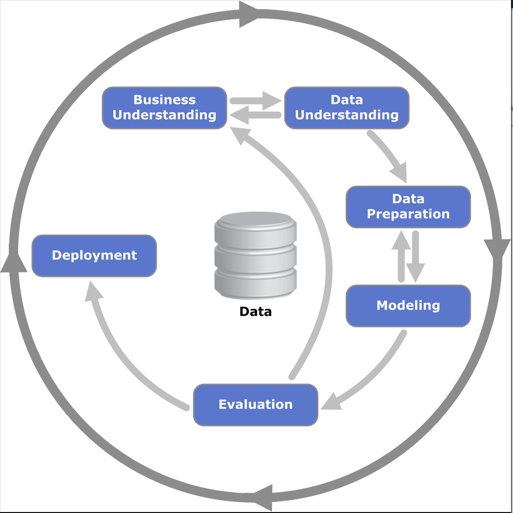



## 2. Entendimiento del negocio

Como se expone en el enunciado, lo que se pretende es estimar la **facturación de cada cliente**. Concretamente, lo que vamos a ilustrar es como estimar la variable TotalFacturado del *dataset* "VALTEL_Clientes.csv".

### 3. Descripción general de los datos

In [3]:
# Definir la ruta al archivofile_path = Path('./0_Data/VALTEL_Clientes.csv')


In [4]:
# Verificar tamaño del fichero
print(f"Tamaño del fichero: {file_path.stat().st_size} bytes")

# Contar el número total de líneas
with open(file_path, 'r') as f:
    line_count = sum(1 for line in f)
print(f"Número total de líneas: {line_count}\n")

# Ver primeras 10 líneas
with open(file_path, 'r') as f:
    lines =  [line for line in f]
    print("Primeras 5 líneas:")
    for line in lines[:5]:
        print(line.strip())
    print("Últimas 5 líneas:")
    for line in lines[-5:]:
        print(line.strip())


Tamaño del fichero: 1014397 bytes
Número total de líneas: 7044

Primeras 5 líneas:
IdCliente;Sexo;Jubilado;Pareja;Dependientes;Antigüedad;Teléfono;MultiplesLíneas;Internet;SeguridadOnline;BackupOnline;SeguroDispositivo;SoporteTécnico;Televisión;Cine;Contrato;FacturaElectrónica;MétodoPago;CargoMensual;TotalFacturado;Baja
7590-VHVEG;Mujer;0;Sí;No;1;No;Sin servicio de telefonía;DSL;No;Sí;No;No;No;No;Mes a mes;Sí;Cheque electrónico;29.85;29.85;No
5575-GNVDE;Hombre;0;No;No;34;Sí;No;DSL;Sí;No;Sí;No;No;No;Un año;No;Cheque por correo;56.95;1889.5;No
3668-QPYBK;Hombre;0;No;No;2;Sí;No;DSL;Sí;Sí;No;No;No;No;Mes a mes;Sí;Cheque por correo;53.85;108.15;Sí
7795-CFOCW;Hombre;0;No;No;45;No;Sin servicio de telefonía;DSL;Sí;No;Sí;Sí;No;No;Un año;No;Transferencia bancaria (automática);42.3;1840.75;No
Últimas 5 líneas:
6840-RESVB;Hombre;0;Sí;Sí;24;Sí;Sí;DSL;Sí;No;Sí;Sí;Sí;Sí;Un año;Sí;Cheque por correo;84.8;1990.5;No
2234-XADUH;Mujer;0;Sí;Sí;72;Sí;Sí;Fibra óptica;No;Sí;Sí;No;Sí;Sí;Un año;Sí;Tarjeta crédit

In [5]:
df = pd.read_csv(file_path, sep=';', encoding='ISO-8859-1') # como la codificación del fichero es ANSI, hay que ponerla explícitamente, igual que el separador ";"
dash_table.DataTable.max_columns = 30 # Establecer el límite de columnas a 30 (por defecto es 20)

Veamos el tipo de datos de cada variable:

In [6]:
print(df.dtypes)

IdCliente              object
Sexo                   object
Jubilado                int64
Pareja                 object
Dependientes           object
Antigüedad              int64
Teléfono               object
MultiplesLíneas        object
Internet               object
SeguridadOnline        object
BackupOnline           object
SeguroDispositivo      object
SoporteTécnico         object
Televisión             object
Cine                   object
Contrato               object
FacturaElectrónica     object
MétodoPago             object
CargoMensual          float64
TotalFacturado         object
Baja                   object
dtype: object


De este primer vistazo, se puede observar que: 
*  **TotalFacturado** nos lo interpreta como una variable categórica, cuando debería ser numérica contínua. Esto es debido a que existen valores con un espacio en blancoDebemos eliminarlos y forzar a que lo interprete adecuadamente.
*  **Jubilado** nos lo interpreta como un número al ser 0 o 1. Vamos a forzarlo a que sea una variable categórica.

#### 3.1 Detección de nulos

Aunque hemos detectado ya valores nulos en el campo TotalFacturado y lo hemos corregido para trabajar más cómodamente, vamos a ver aquí el procedimiento que seguiríamos para detectarlos:

In [7]:
print("Número de filas válidas por columna:")
print(df.count().to_string())
print()

Número de filas válidas por columna:
IdCliente             7043
Sexo                  7043
Jubilado              7043
Pareja                7043
Dependientes          7043
Antigüedad            7043
Teléfono              7043
MultiplesLíneas       7043
Internet              7043
SeguridadOnline       7043
BackupOnline          7043
SeguroDispositivo     7043
SoporteTécnico        7043
Televisión            7043
Cine                  7043
Contrato              7043
FacturaElectrónica    7043
MétodoPago            7043
CargoMensual          7043
TotalFacturado        7043
Baja                  7043



In [8]:
# Reemplazar blancos por 0 y forzar a conversión numérica.
df["TotalFacturado"] = df["TotalFacturado"].replace(' ', 0)
df["TotalFacturado"] = pd.to_numeric(df["TotalFacturado"])

# df["Jubilado"] = df["Jubilado"].astype(str)

print (df.dtypes)

IdCliente              object
Sexo                   object
Jubilado                int64
Pareja                 object
Dependientes           object
Antigüedad              int64
Teléfono               object
MultiplesLíneas        object
Internet               object
SeguridadOnline        object
BackupOnline           object
SeguroDispositivo      object
SoporteTécnico         object
Televisión             object
Cine                   object
Contrato               object
FacturaElectrónica     object
MétodoPago             object
CargoMensual          float64
TotalFacturado        float64
Baja                   object
dtype: object


In [9]:
for col in df.select_dtypes(exclude='number').columns:
    if col != 'IdCliente':
        print(f"Columna: {col}")
        print(df[col].value_counts())
        print("-" * 40)

Columna: Sexo
Sexo
Hombre    3555
Mujer     3488
Name: count, dtype: int64
----------------------------------------
Columna: Pareja
Pareja
No    3641
Sí    3402
Name: count, dtype: int64
----------------------------------------
Columna: Dependientes
Dependientes
No    4933
Sí    2110
Name: count, dtype: int64
----------------------------------------
Columna: Teléfono
Teléfono
Sí    6361
No     682
Name: count, dtype: int64
----------------------------------------
Columna: MultiplesLíneas
MultiplesLíneas
No                           3390
Sí                           2971
Sin servicio de telefonía     682
Name: count, dtype: int64
----------------------------------------
Columna: Internet
Internet
Fibra óptica    3096
DSL             2421
No              1526
Name: count, dtype: int64
----------------------------------------
Columna: SeguridadOnline
SeguridadOnline
No                          3498
Sí                          2019
Sin servicio de Internet    1526
Name: count, dtype: int64

#### 3.2 Análisis Univariante

Para comenzar el análisis univariante, vamos a crear dos dataframe separados con las variables cualitativas y las cuantitativas, donde nos preparamos los estadísticos básicos de cada una. Esto nos facilitará el estudio por separado.

In [10]:
def analyze_df(df):
  data_types = dict(df.dtypes)
  numeric_cols = []
  categoric_cols = []
  for c,t in data_types.items():
    if t == np.float64:
      numeric_cols.append([c, 'Cuantitativa continua', df[c].mean(), df[c].min(), df[c].max(), df[c].median()])
    elif t == np.int64 or pd.Int64Dtype.is_dtype(t):
      numeric_cols.append([c, 'Cuantitativa discreta', df[c].mean(), df[c].min(), df[c].max(), df[c].median()])
    else:
      categoric_cols.append([c, f'Cualitativa', df[c].nunique()])
  n = pd.DataFrame(numeric_cols, columns=['Nombre', 'Tipo de variable', 'Media', 'Mínimo', 'Máximo', 'Mediana'])
  c = pd.DataFrame(categoric_cols, columns=['Nombre', 'Tipo de variable', 'Número de clases'])
  return n, c

numeric_types, categoric_types = analyze_df(df)

In [11]:
print(f"Variables cuantitativas: \n {numeric_types.head()} \n")
print(f"Variables categóricas: \n {categoric_types.head()}")

Variables cuantitativas: 
            Nombre       Tipo de variable   Media  Mínimo  Máximo  Mediana
0        Jubilado  Cuantitativa discreta    0.16    0.00    1.00     0.00
1      Antigüedad  Cuantitativa discreta   32.37    0.00   72.00    29.00
2    CargoMensual  Cuantitativa continua   64.76   18.25  118.75    70.35
3  TotalFacturado  Cuantitativa continua 2279.73    0.00 8684.80  1394.55 

Variables categóricas: 
          Nombre Tipo de variable  Número de clases
0     IdCliente      Cualitativa              7043
1          Sexo      Cualitativa                 2
2        Pareja      Cualitativa                 2
3  Dependientes      Cualitativa                 2
4      Teléfono      Cualitativa                 2


#### 3.2.1 Variables Cualitativas

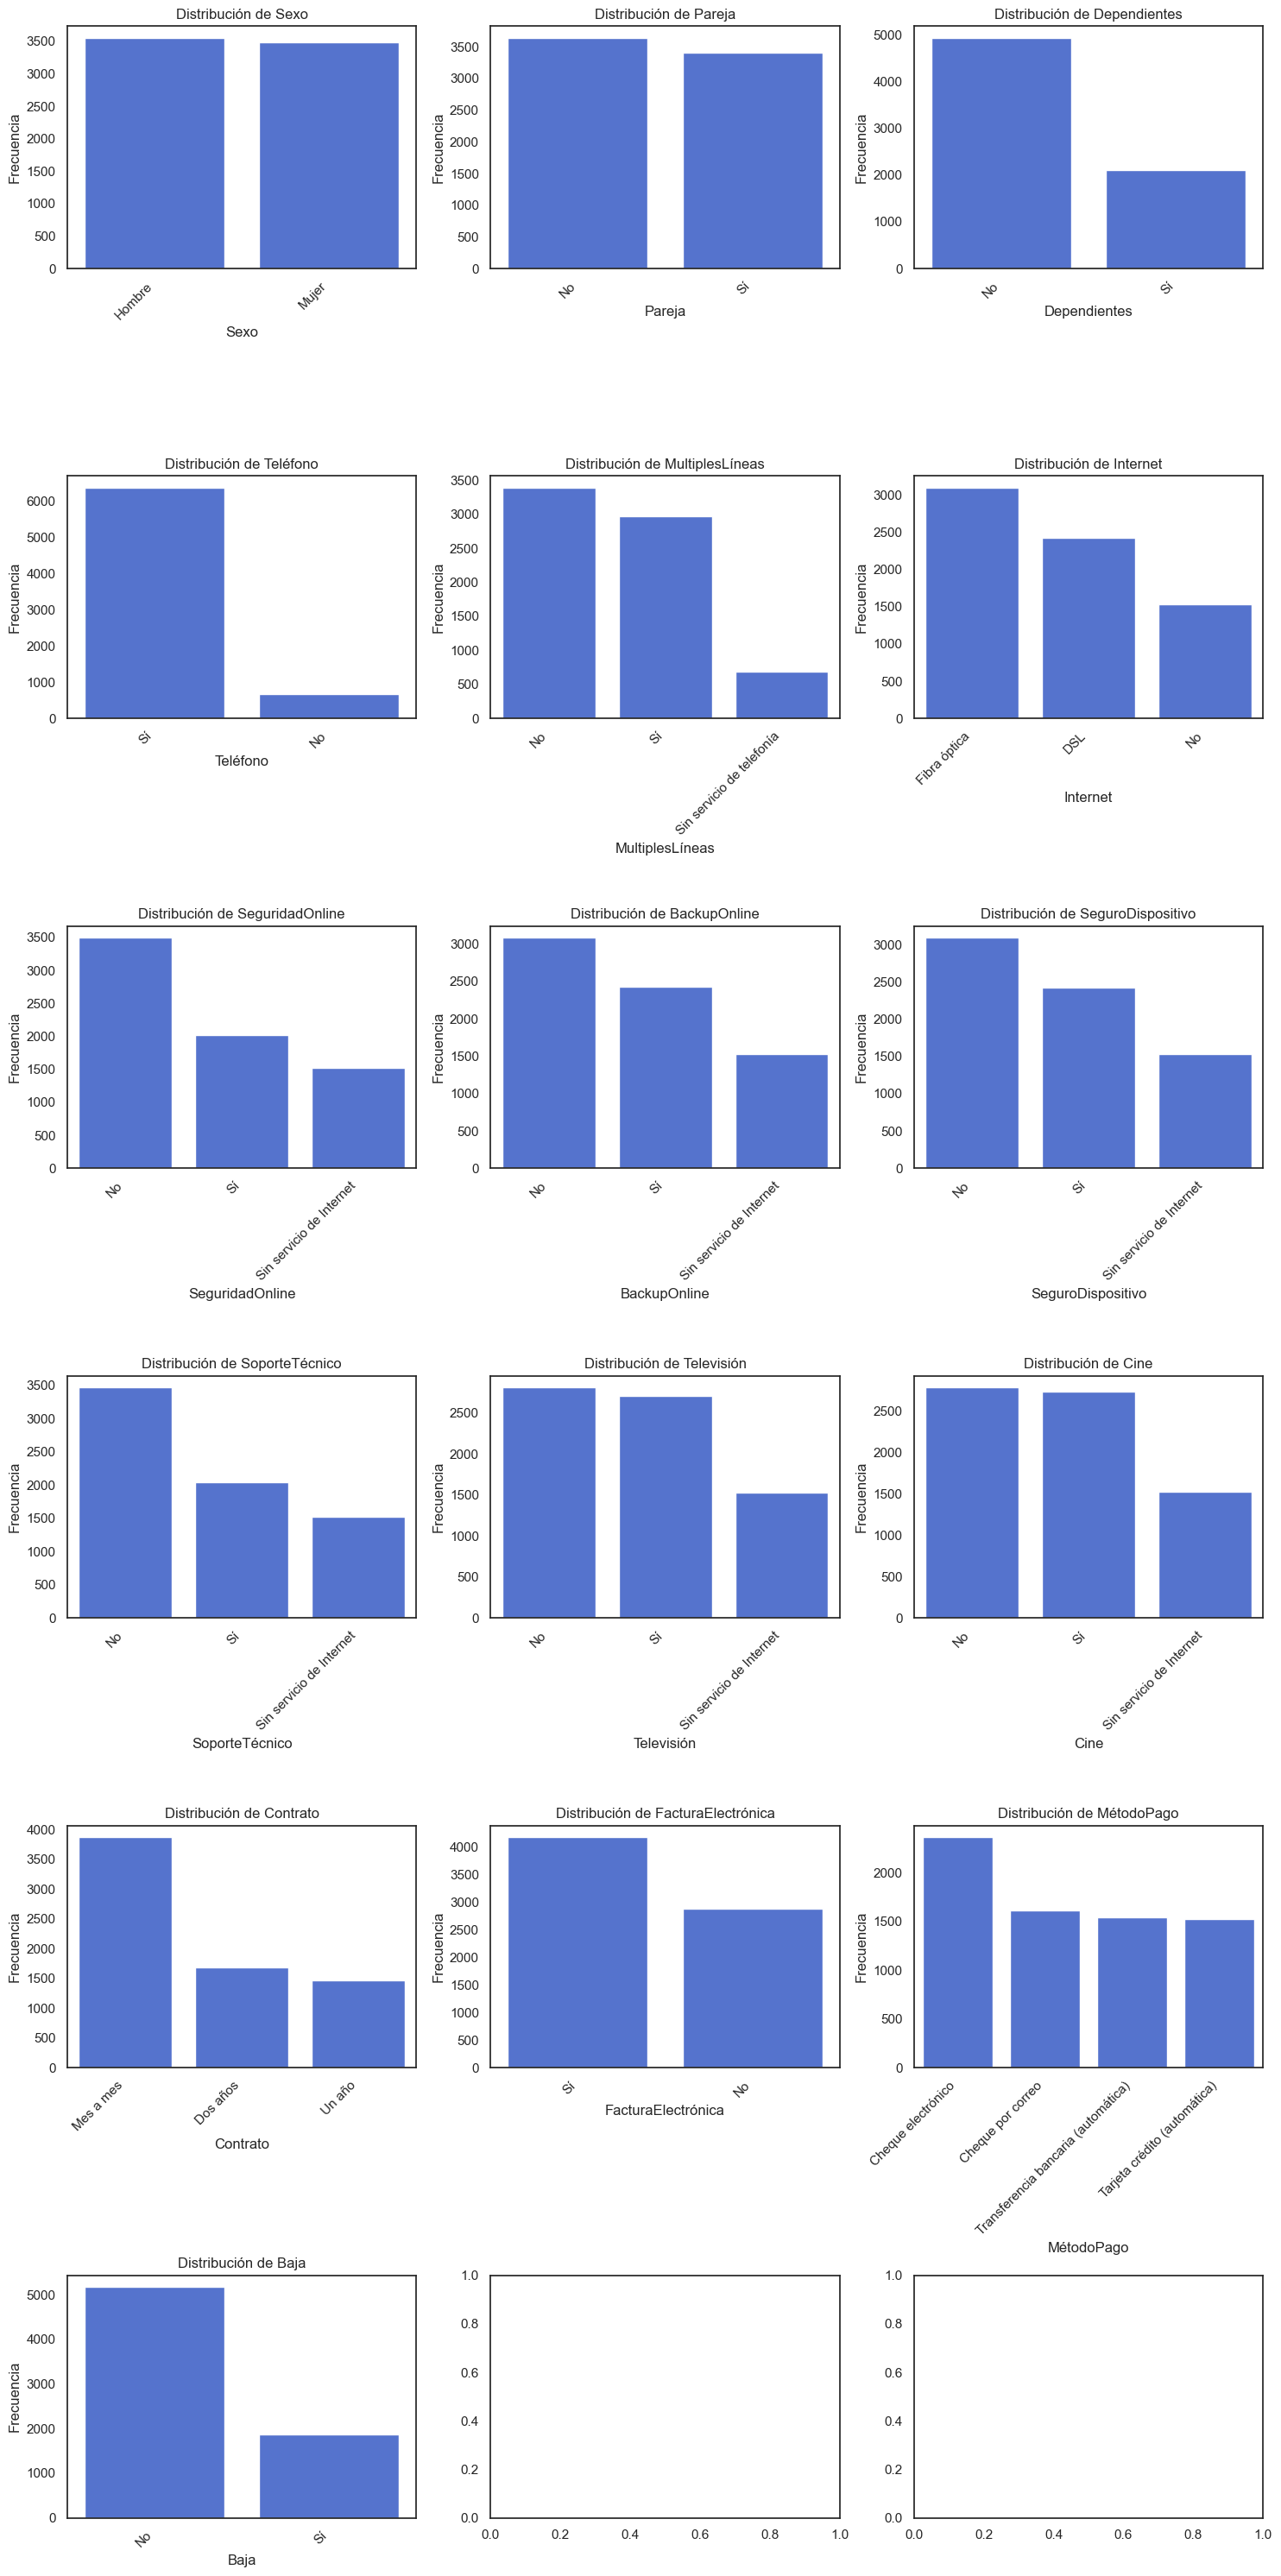

In [12]:
plot_categorical_distributions(df, categoric_types, excluded_column='IdCliente', n_cols=3)

#### 3.2.2 Variables Cuantitativas


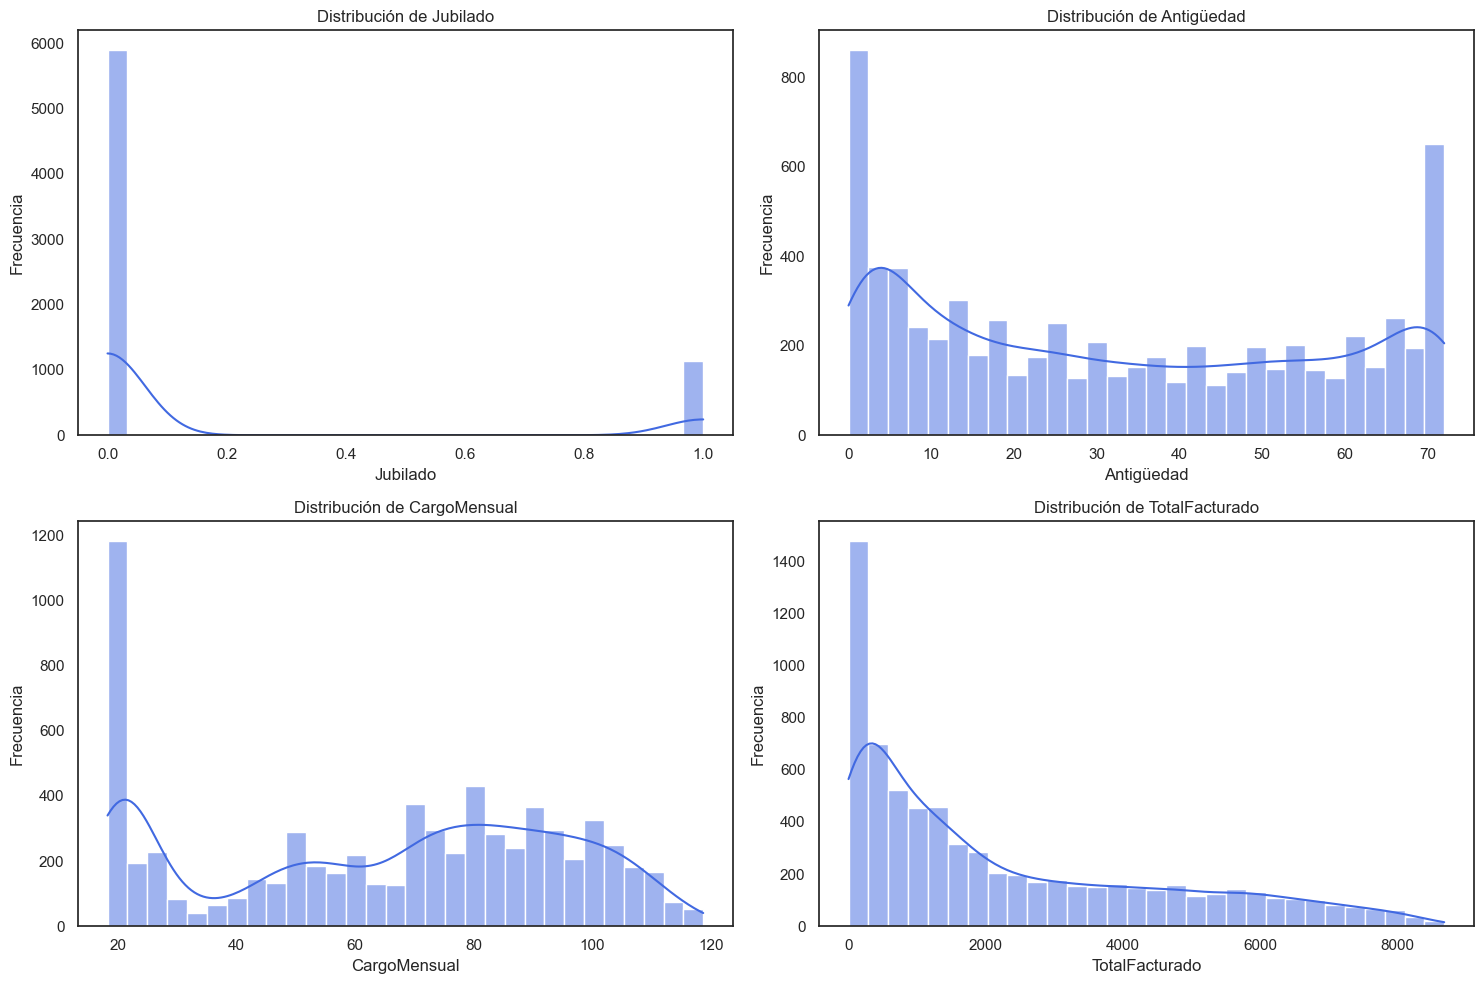

In [13]:
plot_numeric_distributions(df, numeric_types, n_cols=2)

### 3.3. Análisis Bivariante

Vamos a realizar el análisis de cada variable frente a la variable objetivo que en este caso es el TotalFacturado.

#### 3.3.1 Variables Cualitativas vs Variable Objetivo


Para conocer el comportamiento de las variables cualitativas frente a la variable objetivo vamos a utilizar el BarPlot.

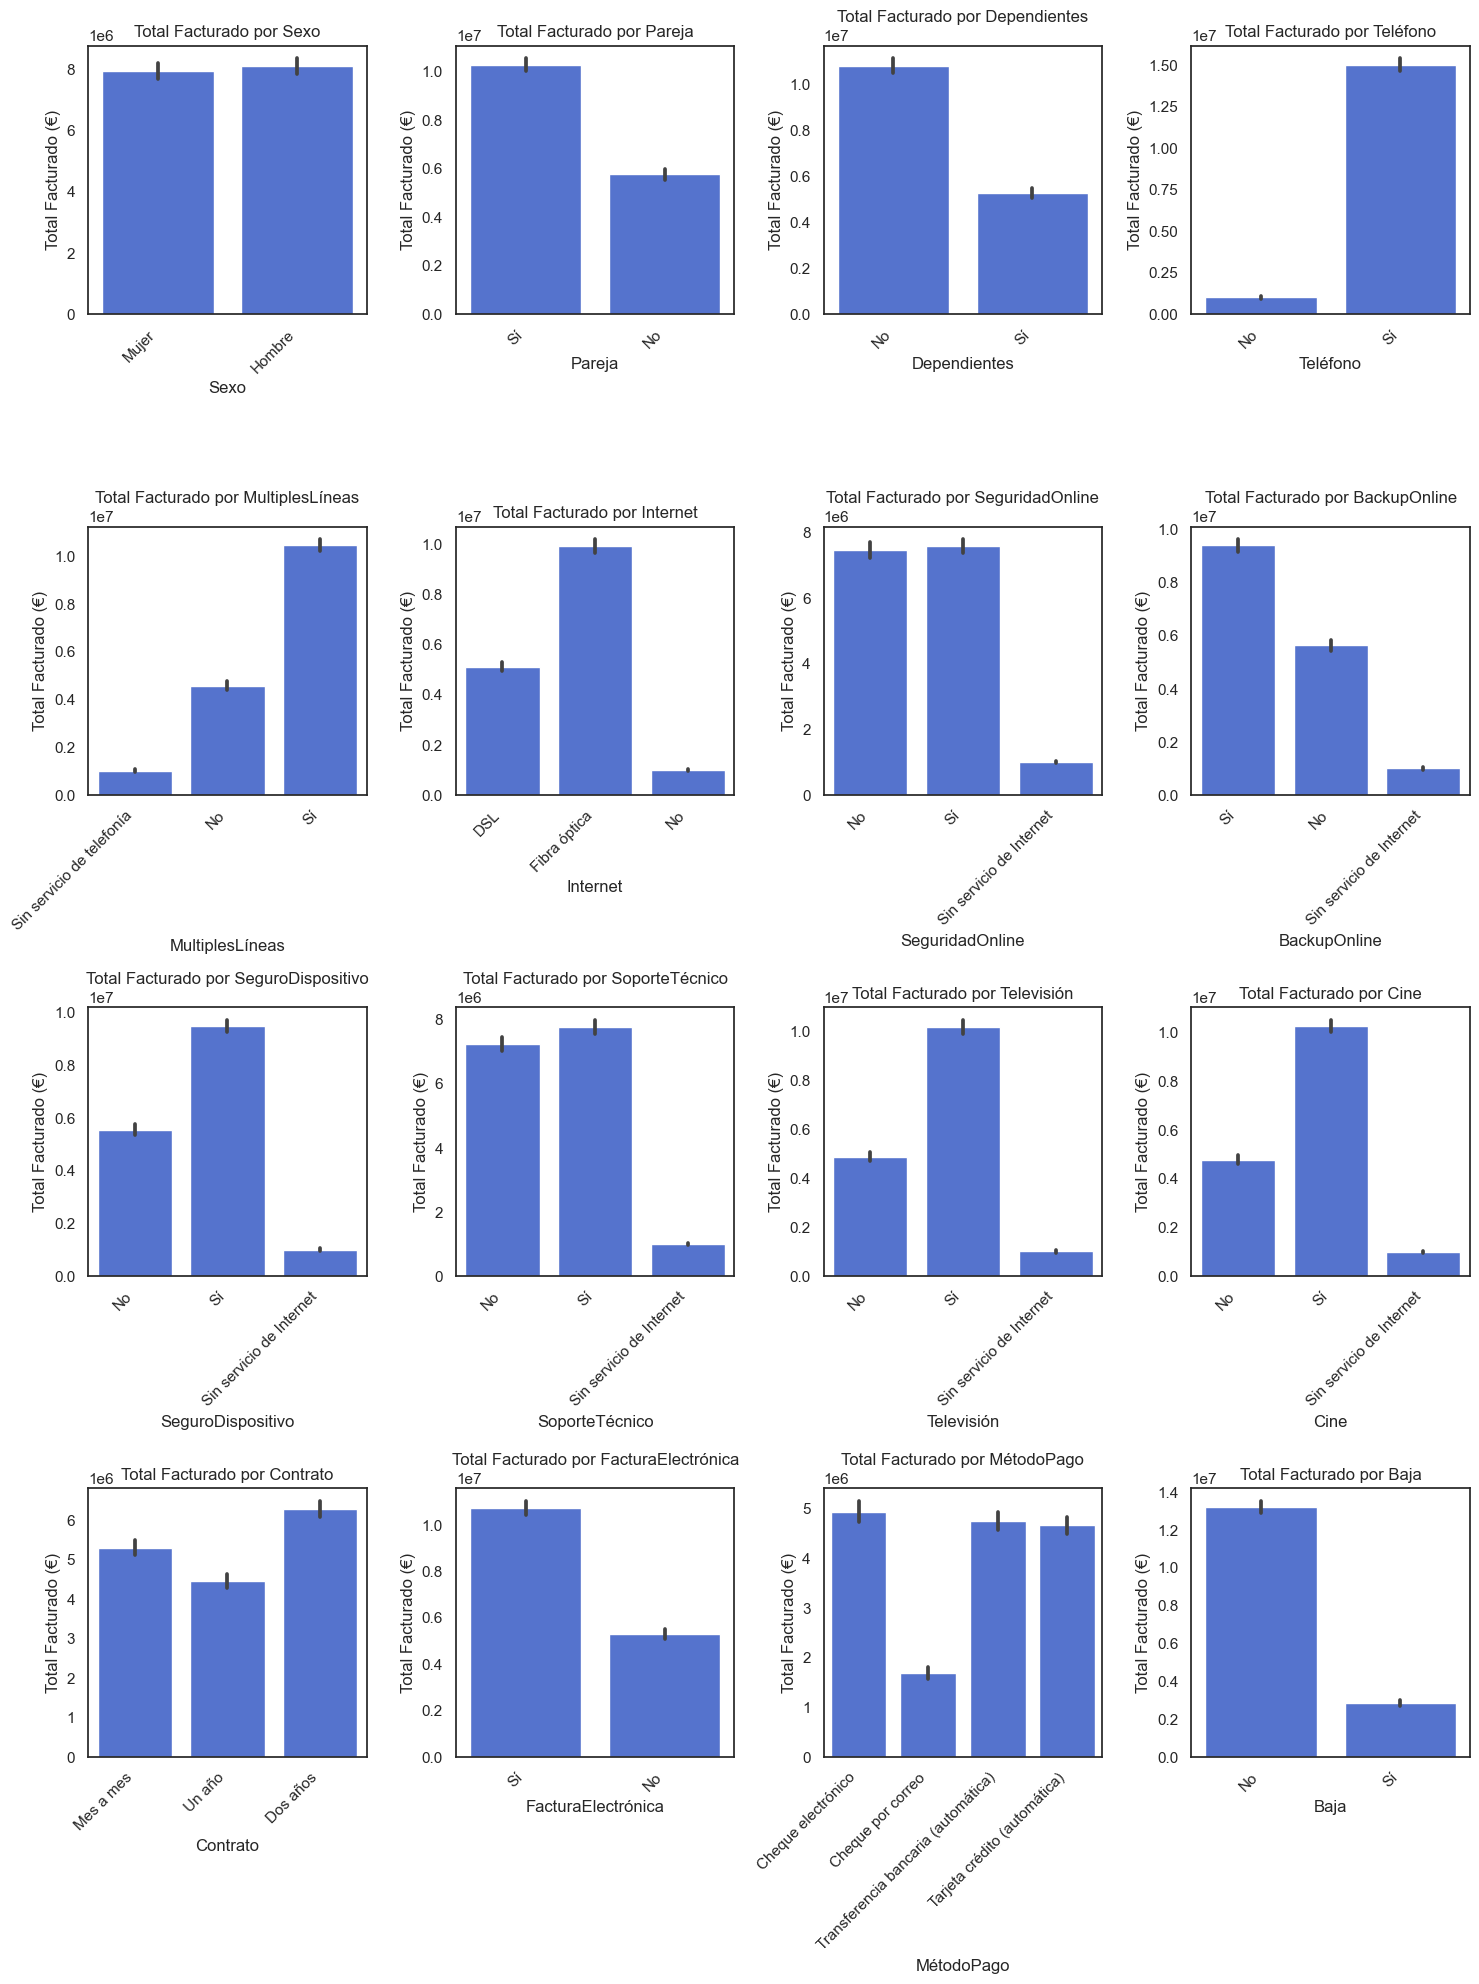

In [14]:
plot_categorical_distributions(df, categoric_types, excluded_column='IdCliente', n_cols=4, plot_type='barplot')

Observe por cada variable, si hay una distribución uniforme de los valores o no, que nos indique posibles relaciones.

#### 3.3.2 Variables Cuantitativas vs Variable Objetivo

Para conocer el comportamiento de las variables cuantitativas frente a la variable objetivo vamos a utilizar el ScatterPlot.

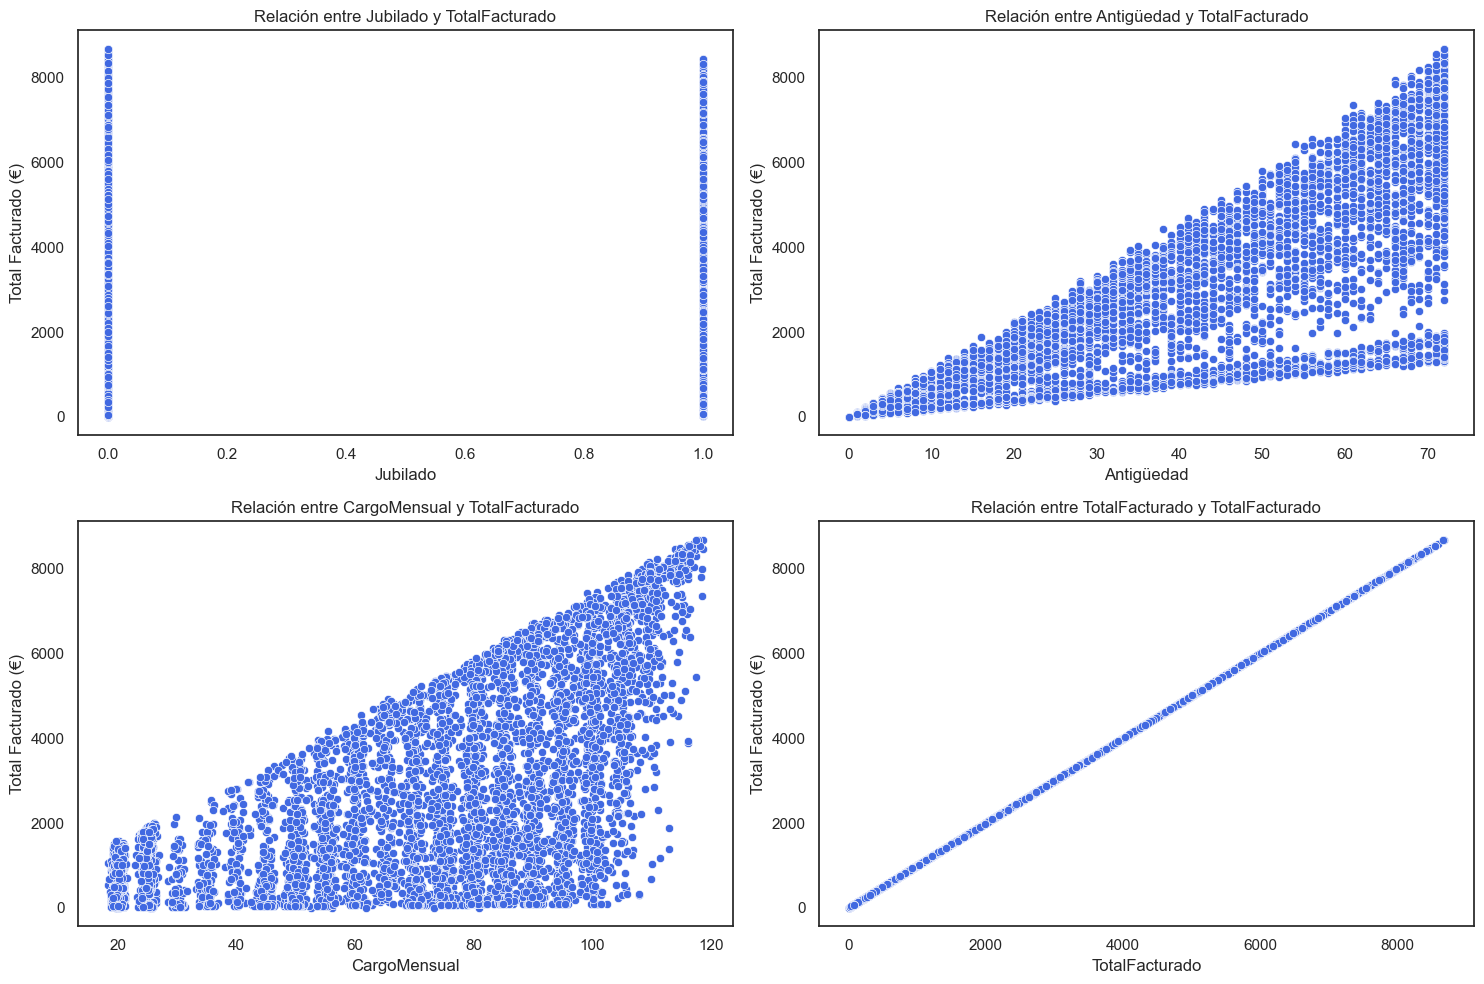

In [15]:
plot_numeric_distributions(df, numeric_types, n_cols=2, plot_type='scatterplot')

Observe por cada variable, si hay una distribución uniforme de los valores o no, que nos indique posibles relaciones.

### 3.4. Análisis Multivariante

Tras el estudio frente a la variable objetivo, vamos a calcular la matriz de correlación para ver las dependencias entre variables cuantitativas.

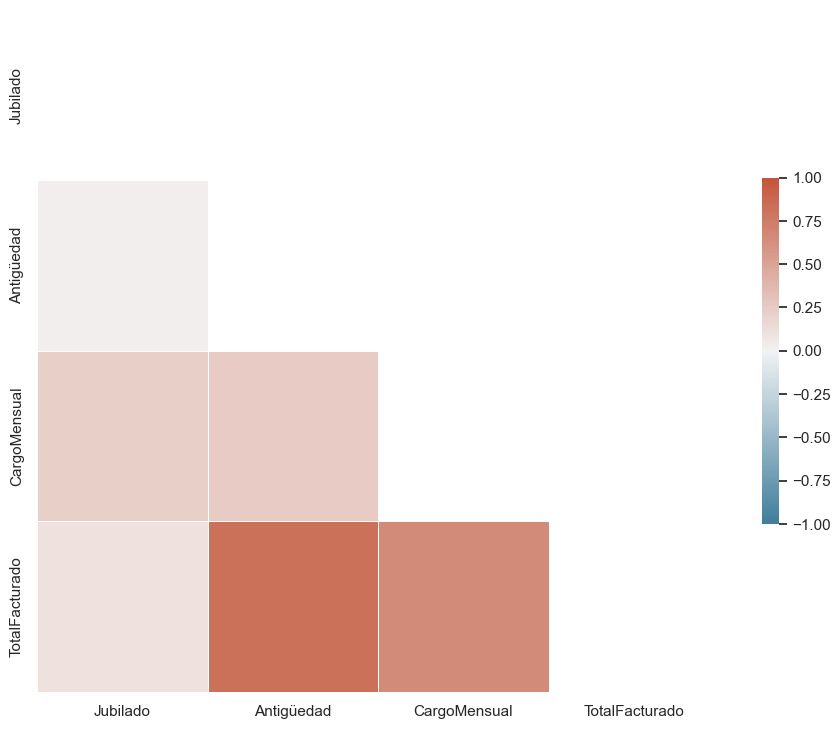

In [16]:
corr = df[numeric_types['Nombre']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.set_theme(style="white")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

Para analizar de forma gráfica, la relación entre dos variables cualitativas, podemos utilizar un heatmap de la siguiente forma:

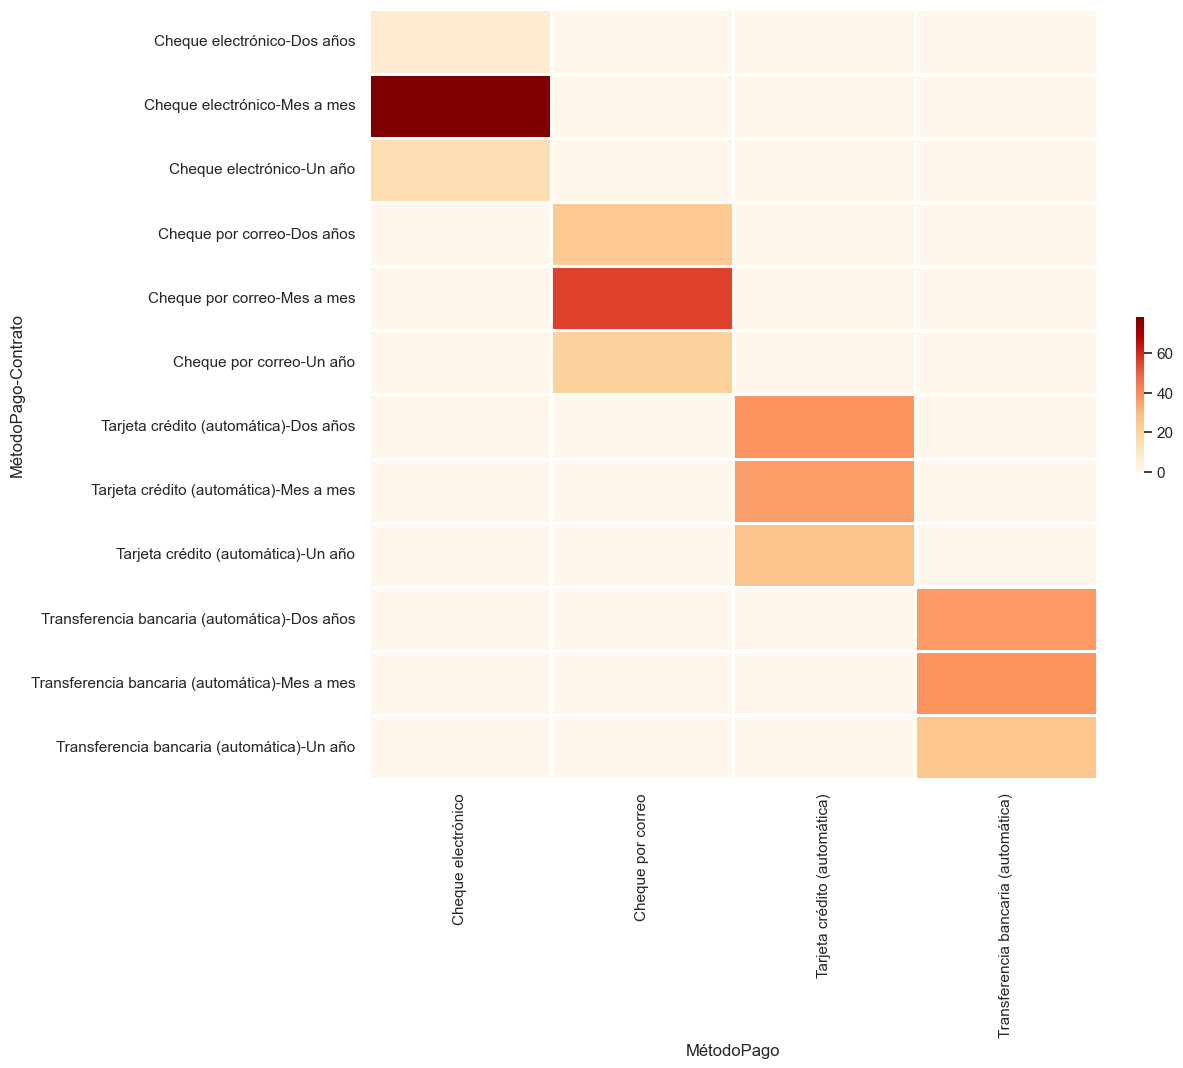

In [17]:
by_maker = (df
            .groupby(['Contrato', 'MétodoPago'])
            .size()
            .groupby(level=1)
            .apply(lambda x: 100 * x / float(x.sum()))
            .unstack()
           )
by_maker.fillna(0, inplace=True)
plt.figure(figsize=(10,10))
g = sns.heatmap(
    by_maker, 
    square=False, # make cells square
    cbar_kws={'fraction' : 0.01}, # shrink colour bar
    cmap='OrRd', # use orange/red colour map
    linewidth=1 # space between cells
)

### 3.5. Calidad del dato

#### 3.5.1 Detectar valores atípicos

Analizamos los valores atípicos de las variables cuantitativas para descartarlos posteriormente.

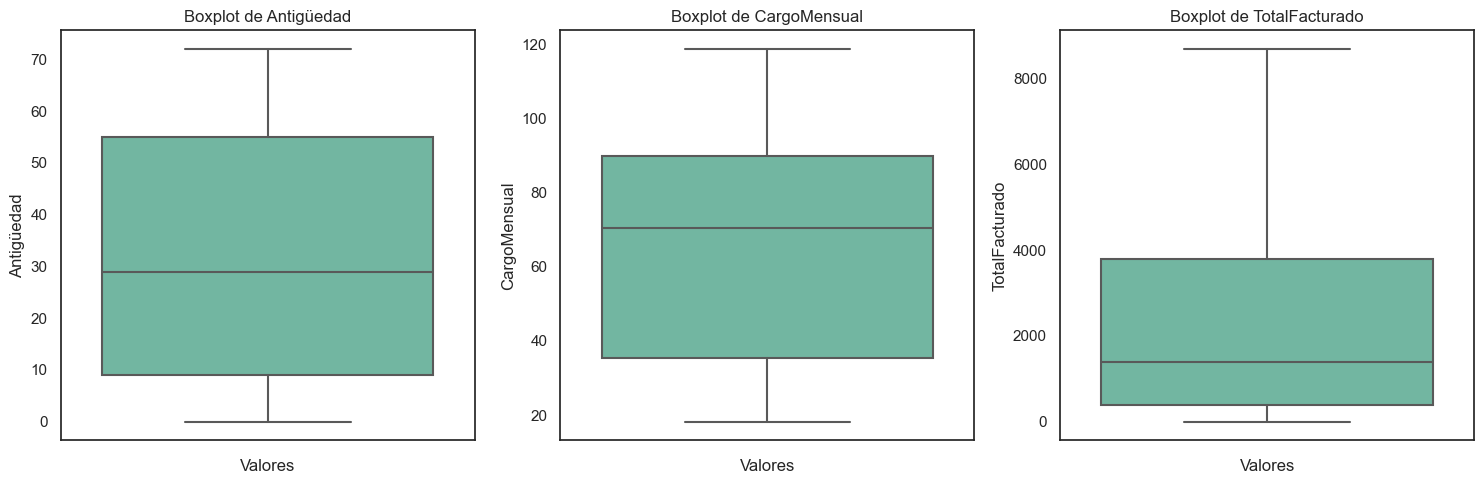

In [18]:
columns_to_plot = ['Antigüedad', 'CargoMensual', 'TotalFacturado']

fig, axs = plt.subplots(figsize=(15, 5), ncols=len(columns_to_plot), sharey=False)

for i, col in enumerate(columns_to_plot):
    sns.boxplot(data=df, y=col, ax=axs[i], palette="Set2", orient='h')
    axs[i].set_title(f"Boxplot de {col}")
    axs[i].set_xlabel("Valores")
    axs[i].set_ylabel(col)

plt.tight_layout()
plt.show()

## 4. Preparación de los datos

### 4.1. Seleccionar los datos

Seleccionamos las variables que son de nuestro interés. En este caso vamos a descartar el campo IdCliente

In [19]:
df = df.drop(['IdCliente'], axis=1, errors='ignore')

### 4.2 Limpieza de datos

#### 4.2.1 Eliminar nulos

In [20]:
print("Eliminando datos nulos:")
print()
df = df.dropna()
#Aprovechamos para formatear los tipos de datos correctamente
df = df.astype({"TotalFacturado": float})
df = df.astype({"Antigüedad": int})
df = df.astype({"Jubilado": int})
print("Número de filas válidas por columna:")
print(df.count().to_string())

Eliminando datos nulos:

Número de filas válidas por columna:
Sexo                  7043
Jubilado              7043
Pareja                7043
Dependientes          7043
Antigüedad            7043
Teléfono              7043
MultiplesLíneas       7043
Internet              7043
SeguridadOnline       7043
BackupOnline          7043
SeguroDispositivo     7043
SoporteTécnico        7043
Televisión            7043
Cine                  7043
Contrato              7043
FacturaElectrónica    7043
MétodoPago            7043
CargoMensual          7043
TotalFacturado        7043
Baja                  7043


#### 4.2.2 Eliminar registros duplicados

In [21]:
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")
print()
print("Eliminando filas con valores duplicados...")
df = df.drop_duplicates().reset_index(drop=True)
print()
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

Número de filas: 7043
Número de columnas: 20

Eliminando filas con valores duplicados...

Número de filas: 7021
Número de columnas: 20


In [22]:
df.count()

Sexo                  7021
Jubilado              7021
Pareja                7021
Dependientes          7021
Antigüedad            7021
Teléfono              7021
MultiplesLíneas       7021
Internet              7021
SeguridadOnline       7021
BackupOnline          7021
SeguroDispositivo     7021
SoporteTécnico        7021
Televisión            7021
Cine                  7021
Contrato              7021
FacturaElectrónica    7021
MétodoPago            7021
CargoMensual          7021
TotalFacturado        7021
Baja                  7021
dtype: int64

#### 4.2.3 Eliminar valores atípicos

Aunque no hay valores atípicos de las variables numéricas, tal y como hemos visto en los anteriores boxplot, se presenta la forma de eliminarlos. 

Número de filas (con valores atípicos): 7021
Eliminando valores atípicos...
Número de filas (sin valores atípicos): 7021


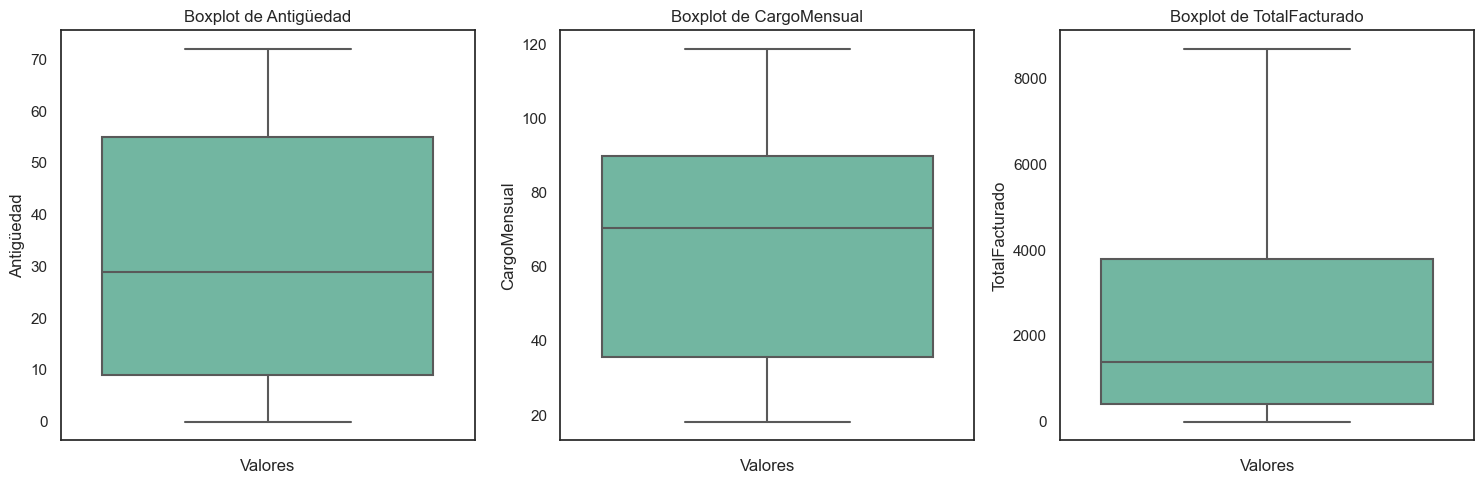

In [23]:
columns_with_outliers = ['Antigüedad', 'CargoMensual', 'TotalFacturado']

print(f"Número de filas (con valores atípicos): {df.shape[0]}")
print("Eliminando valores atípicos...")

# Calcular los percentiles Q1 y Q3 para cada columna
Q1 = df[columns_with_outliers].quantile(0.25)
Q3 = df[columns_with_outliers].quantile(0.75)
IQR = Q3 - Q1

# Filtrar los valores atípicos para cada columna
df2 = df[~((df[columns_with_outliers] < (Q1 - 1.5 * IQR)) | (df[columns_with_outliers] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Número de filas (sin valores atípicos): {df2.shape[0]}")

# Generar los gráficos de caja para las columnas numéricas
fig, axs = plt.subplots(figsize=(15, 5), ncols=len(columns_with_outliers), sharey=False)

for i, col in enumerate(columns_with_outliers):
    sns.boxplot(data=df, y=col, ax=axs[i], palette="Set2", orient='h')
    axs[i].set_title(f"Boxplot de {col}")
    axs[i].set_xlabel("Valores")
    axs[i].set_ylabel(col)

plt.tight_layout()
plt.show()

### 4.3 Construir

Vamos a incluir un ejemplo de **normalización** de la variable Antigüedad:

In [24]:
print('5 primeras columnas de la columna Antigüedad ANTES de normalizarla')
print(df['Antigüedad'].head())

scaler = MinMaxScaler()
df2[['Antigüedad']] = scaler.fit_transform(df2[['Antigüedad']])

print('5 primeras columnas de la columna Antigüedad DESPUÉS de normalizarla')
print(df2['Antigüedad'].head())

5 primeras columnas de la columna Antigüedad ANTES de normalizarla
0     1
1    34
2     2
3    45
4     2
Name: Antigüedad, dtype: int32
5 primeras columnas de la columna Antigüedad DESPUÉS de normalizarla
0   0.01
1   0.47
2   0.03
3   0.62
4   0.03
Name: Antigüedad, dtype: float64


### 4.4. Formatear

Como la mayor parte de modelos de machine learning en scikit-learn necesitan variables numéricas para funcionar, vamos a utilizar una técnica de codificación que nos permite transformar variables categóricas en numéricas.

In [25]:
df_transformed = pd.DataFrame()
for col in list(categoric_types['Nombre']):
    if col != 'IdCliente':  # Evitar la columna 'IdCliente'
        column = col
        ohe = OneHotEncoder(sparse=False)  # Asegurarse de que no sea una matriz dispersa
        transformed = ohe.fit_transform(df2[[col]])
        # Crear un DataFrame con los nuevos nombres de columna para las variables codificadas
        transformed = pd.DataFrame(transformed, columns=ohe.get_feature_names_out([col]))
        # Agregar las nuevas columnas al DataFrame
        df_transformed = pd.concat([df_transformed, transformed], axis=1)  # Agregar las columnas codificadas

# Verificar el tipo de datos de cada columna
df2 = pd.concat([df_transformed, df2[list(numeric_types['Nombre']) ]], axis=1)
print(df2.dtypes)
print(df2.shape)

Sexo_Hombre                                       float64
Sexo_Mujer                                        float64
Pareja_No                                         float64
Pareja_Sí                                         float64
Dependientes_No                                   float64
Dependientes_Sí                                   float64
Teléfono_No                                       float64
Teléfono_Sí                                       float64
MultiplesLíneas_No                                float64
MultiplesLíneas_Sin servicio de telefonía         float64
MultiplesLíneas_Sí                                float64
Internet_DSL                                      float64
Internet_Fibra óptica                             float64
Internet_No                                       float64
SeguridadOnline_No                                float64
SeguridadOnline_Sin servicio de Internet          float64
SeguridadOnline_Sí                                float64
BackupOnline_N

Probemos ahora a detectar posibles correlaciones:

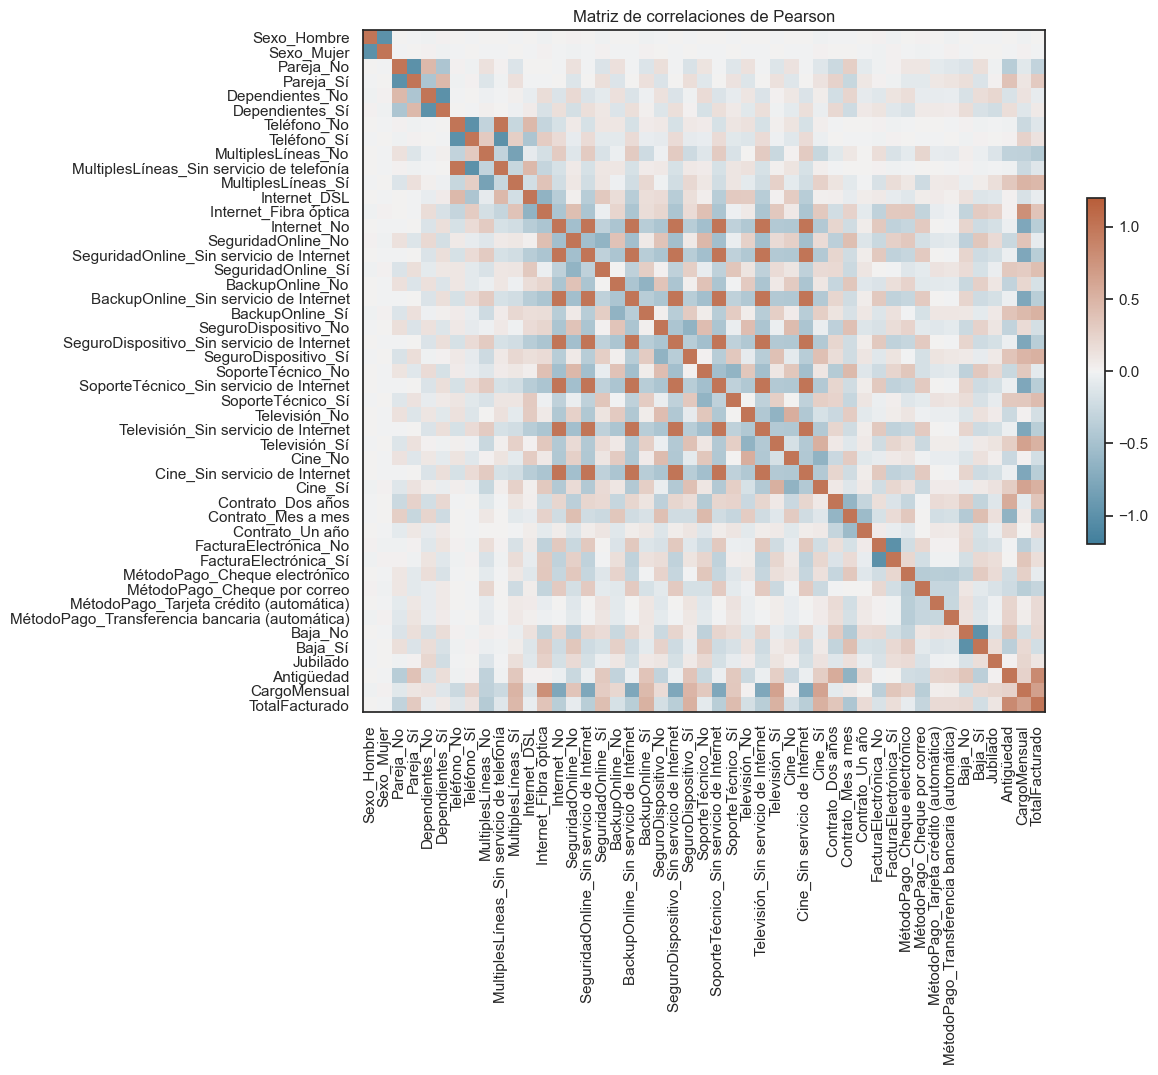

In [26]:
matriz_correlaciones = df2.corr(method='pearson')
n_ticks = len(df2.columns)
plt.figure(figsize=(11, 9))
plt.xticks(range(n_ticks), df2.columns, rotation='vertical')
plt.yticks(range(n_ticks), df2.columns)
cmap = sns.diverging_palette(230, 25, as_cmap=True)
# Generar la imagen de la matriz de correlación
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                        vmin=-1.2, vmax=1.2, 
                        cmap=cmap), shrink=0.5)

# Añadir el título
plt.title('Matriz de correlaciones de Pearson')

# Mostrar el gráfico
plt.show()

Como se puede observar las dos variables cuantitativas, Antigüedad y CargoMensual son las que más correlacionadas se encuentran con nuestra variable objetivo TotalFacturado.

## 5. Desarrollo y Evaluación del modelo

Como queremos estimar una variable cuantitativa, es un problema de regresión y siguiendo la guía de scikit-learn: 
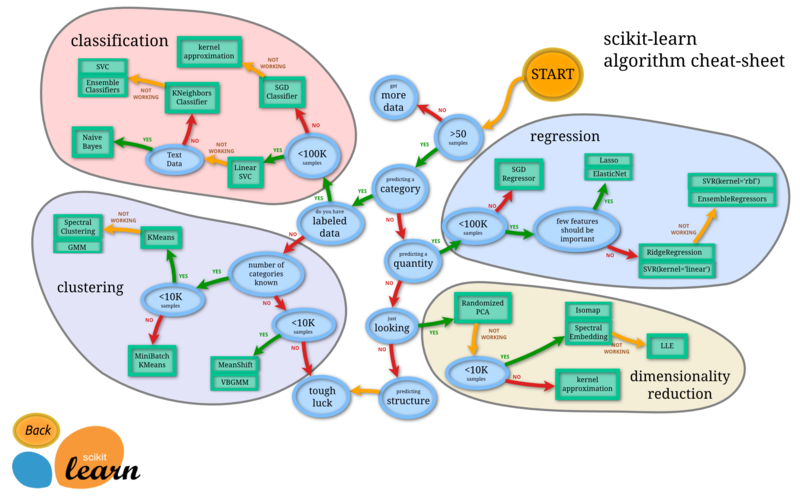



### 5.1 Regresión Lineal Simple

Vamos a probar lo más sencillo, que es utilizar una regresión lineal con la variable explicativa que más correlación presenta (Antigüedad):

Error cuadrático medio (MSE): 0.0213
Coeficiente de determinación (R2): 0.6777


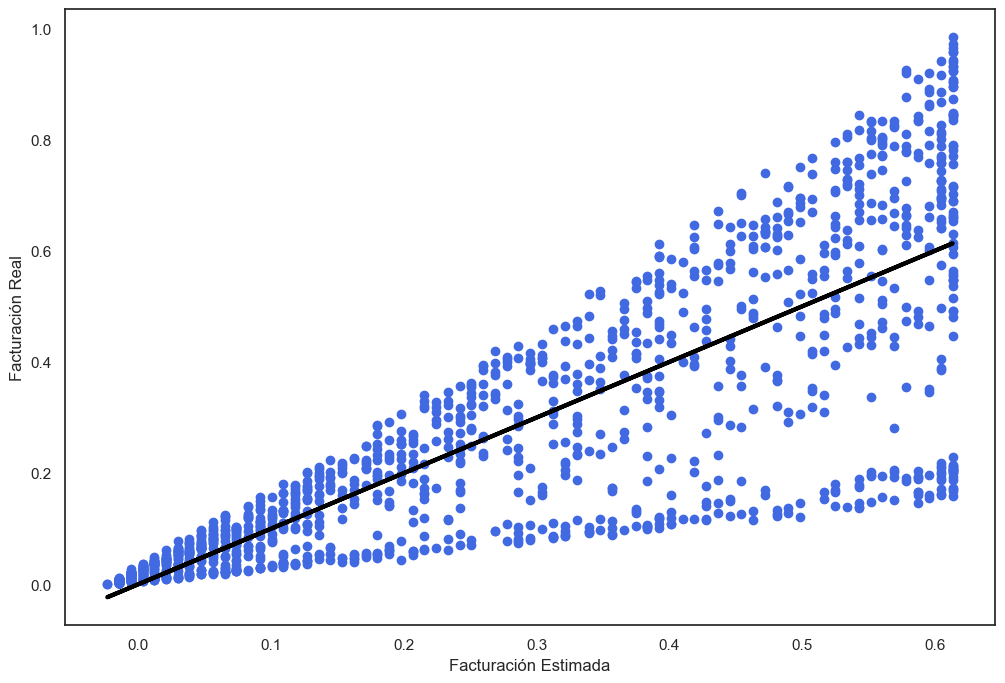

In [27]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

x_cols = ['Antigüedad']
y_cols = ['TotalFacturado']

# Normalizamos las dos variables, para poder interpretar mejor los resultados
scaler = MinMaxScaler()
X = scaler.fit_transform(df2[x_cols])
y = scaler.fit_transform(df2[y_cols])

# Generamos el dataset de entrenamiento y el de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=47)

# Entrenamos el modelo
lg = linear_model.LinearRegression()
lg.fit(X_train, y_train)

# Evaluamos el modelo
y_pred = lg.predict(X_test)

print(f"Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Coeficiente de determinación (R2): {r2_score(y_test, y_pred):.4f}")

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_pred, y_test,  color='royalblue')
plt.plot(y_pred, y_pred, color='black', linewidth=3)

plt.xlabel('Facturación Estimada')
plt.ylabel('Facturación Real')
plt.show()

Los resultados no son muy espectaculares, pero al menos son lo suficientemente representativos como para ser considerados aceptables.

Veamos si podemos mejorarlo añadiendo más variables a la regresión:

### 5.2 Regresión Lineal Múltiple

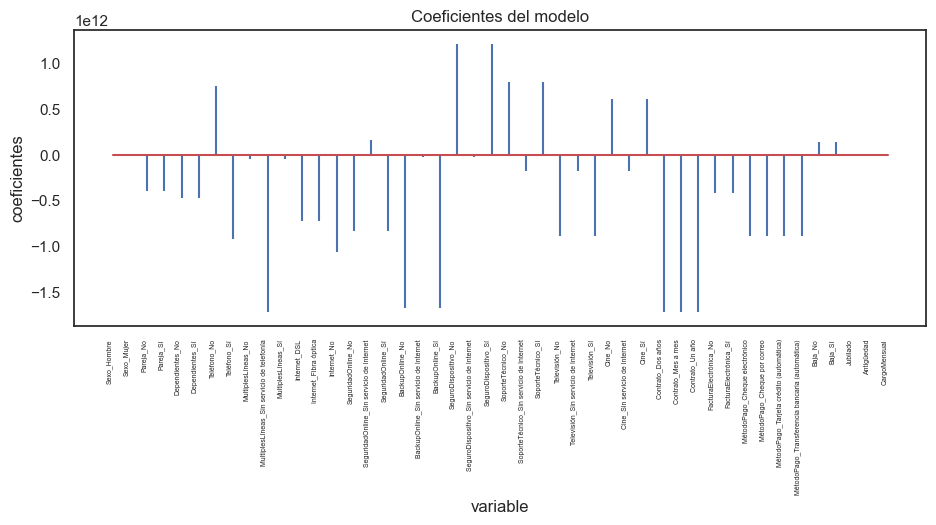

In [28]:
# Cogemos todas las variables explicativas 
X = df2.drop(columns='TotalFacturado')
y = df2['TotalFacturado']

# Normalizamos las variables para interpretar mejor el resultado
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(X.values)
X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)
y = scaler.fit_transform(df2[['TotalFacturado']])


X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# Creación y entrenamiento del modelo
modelo = linear_model.LinearRegression()
modelo.fit(X = X_train, y = y_train)

# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

Como se puede observar CargoMensual también está fuertemente correlada y el resto podríamos despreciar su contribución y eliminarlas. No obstante, vamos a ver si es suficiente para mejorar el anterior modelo:


Error cuadrático medio (MSE): 0.0061
Raíz del Error cuadrático medio (MSE): 0.0783
Coeficiente de determinación (R2): 0.9104


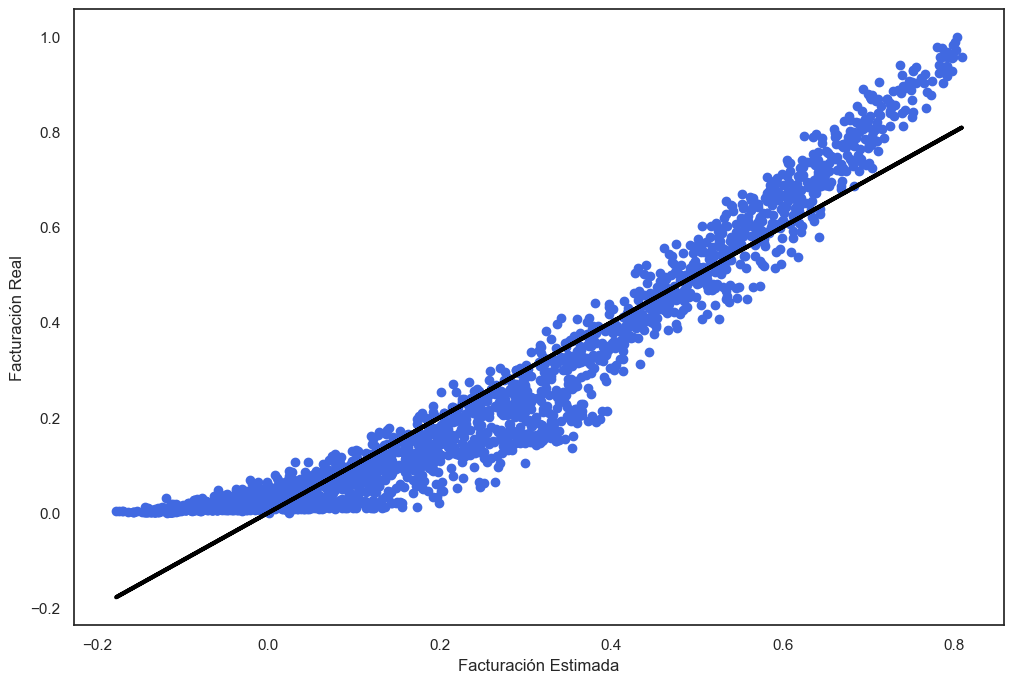

In [29]:
# Evaluamos el modelo
y_pred = modelo.predict(X=X_test)
y_pred = y_pred.flatten()
y_pred[:10]

print("")
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Raíz del Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred,squared=False):.4f}")
print(f"Coeficiente de determinación (R2): {r2_score(y_test, y_pred):.4f}")

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_pred, y_test,  color='royalblue')
plt.plot(y_pred, y_pred, color='black', linewidth=3)

plt.xlabel('Facturación Estimada')
plt.ylabel('Facturación Real')
plt.show()

Ahora observamos que los resultados son mucho mejores: con un coeficiente de determinación tan cercano a 1 se considera una muy buena estimación. 
A continuación, vamos a utilizar las regularizaciones Ridge y Lasso para ver si se comporta mejor:

### 5.3 Regularización Ridge

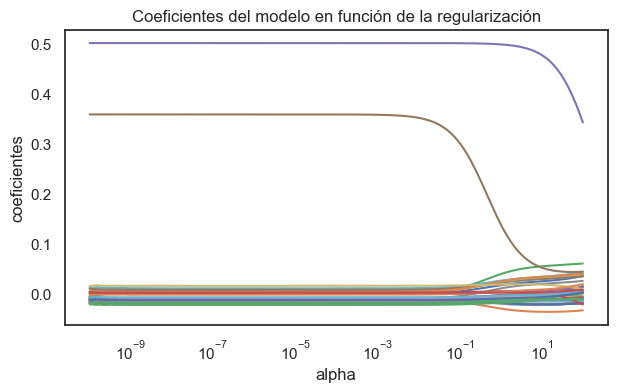

In [30]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# Por defecto RidgeCV utiliza el mean squared error
modelo = linear_model.RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            store_cv_values = True
         )

_ = modelo.fit(X = X_train, y = y_train)


# Evolución de los coeficientes en función de alpha
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = linear_model.Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

Como se puede observar **apenas tiene efecto la regularización** sobre los coeficientes de la regresión lineal, con lo que **deberíamos descartar su utilización**.

A modo ilustrativo, se incluyen los pasos a seguir en caso de que sí fuera relevante

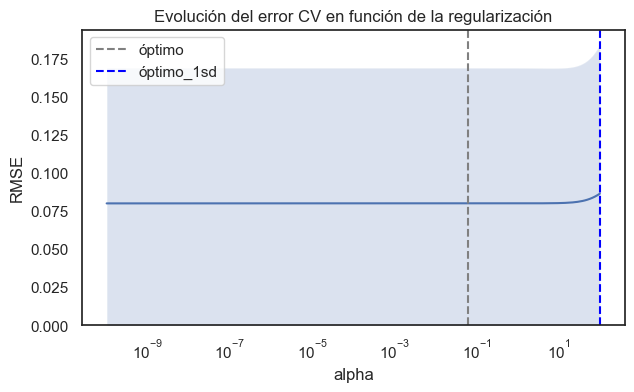

In [31]:
# Evolución del error en función de alpha

# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [32]:
# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 0.06368249944718586


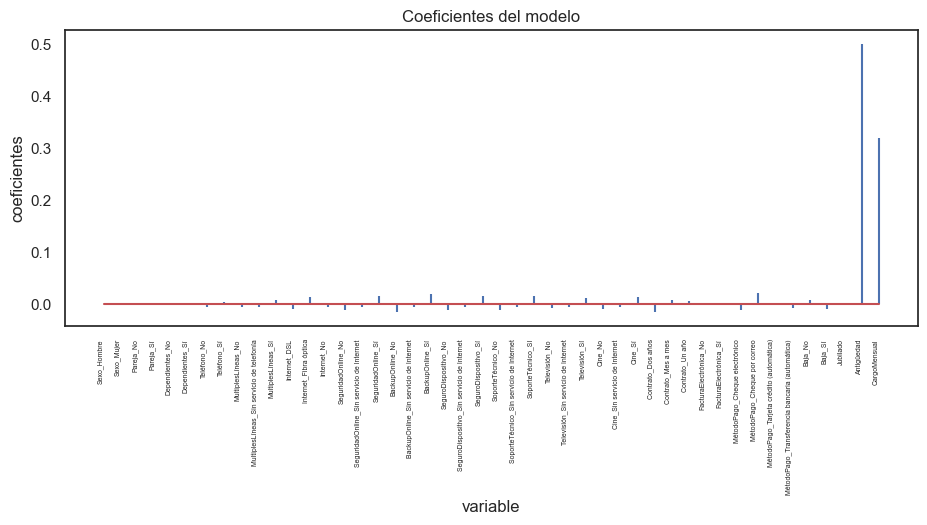

In [33]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

Evaluaríamos la mejor del modelo:

In [34]:
# Predicciones test
y_pred = modelo.predict(X=X_test)
y_pred = y_pred.flatten()
y_pred[:10]

print("")
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Raíz del Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred,squared=False):.4f}")
print(f"Coeficiente de determinación (R2): {r2_score(y_test, y_pred):.4f}")


Error cuadrático medio (MSE): 0.0061
Raíz del Error cuadrático medio (MSE): 0.0781
Coeficiente de determinación (R2): 0.9109


### 5.4 Regularización Lasso

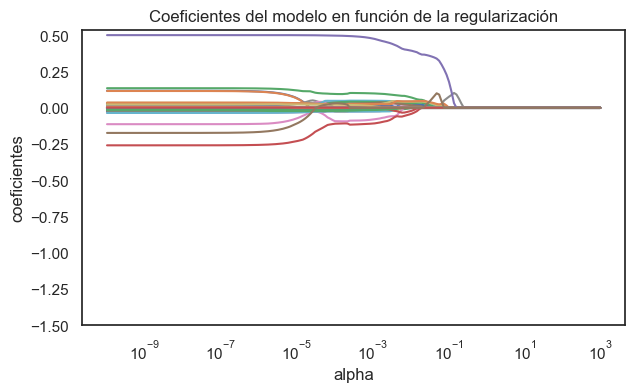

In [35]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# Por defecto LassoCV utiliza el mean squared error
modelo = linear_model.LassoCV(
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10
         )
_ = modelo.fit(X = X_train, y = y_train)

# Evolución de los coeficientes en función de alpha
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_ylim([-1.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');

Como cabía esperar, no vamos a conseguir ningún tipo de mejora y la descartaríamos. De manera análoga a la anterior, vamos a exponer los pasos que se deberían seguir para ejecutarla ya que va a ilustrarnos como deberíamos a ver reducido la dimensionalidad del *dataset*.

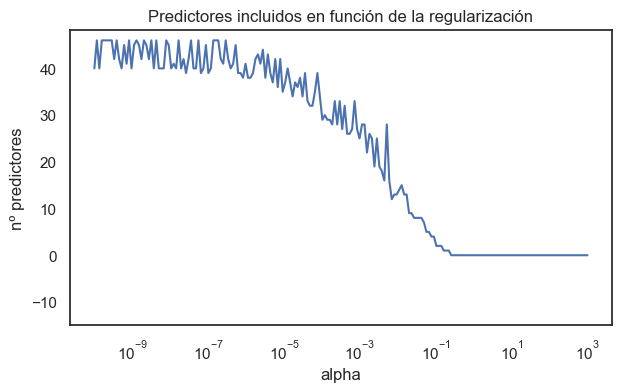

In [36]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = linear_model.Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

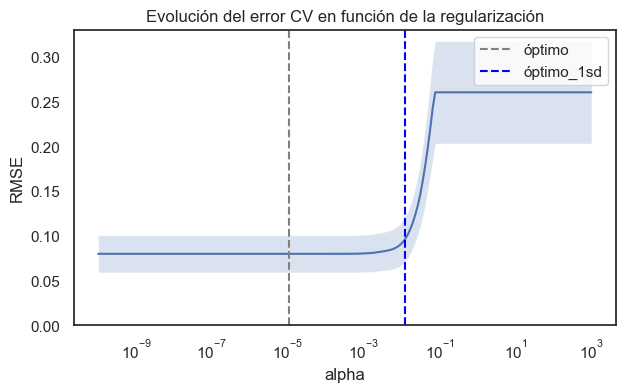

In [37]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [38]:
# Mejor valor alpha encontrado
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 1.0718913192051286e-05


In [39]:
# Mejor valor alpha encontrado + 1sd
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado + 1 desviación estándar: [0.01260383]


In [40]:
# Mejor modelo alpha óptimo + 1sd
modelo = linear_model.Lasso(alpha=optimo_1sd[0])
modelo.fit(X_train, y_train)

Lasso(alpha=0.012603829296797275)

In [41]:
# Coeficientes del modelo
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
10,MultiplesLíneas_Sí,0.02
12,Internet_Fibra óptica,0.06
16,SeguridadOnline_Sí,0.01
19,BackupOnline_Sí,0.04
22,SeguroDispositivo_Sí,0.03
25,SoporteTécnico_Sí,0.02
28,Televisión_Sí,0.04
31,Cine_Sí,0.04
44,Antigüedad,0.41
45,CargoMensual,0.06


El resultado es el esperado: sólo se incluyen las dos variables cuantitativas que más correlación tenía.

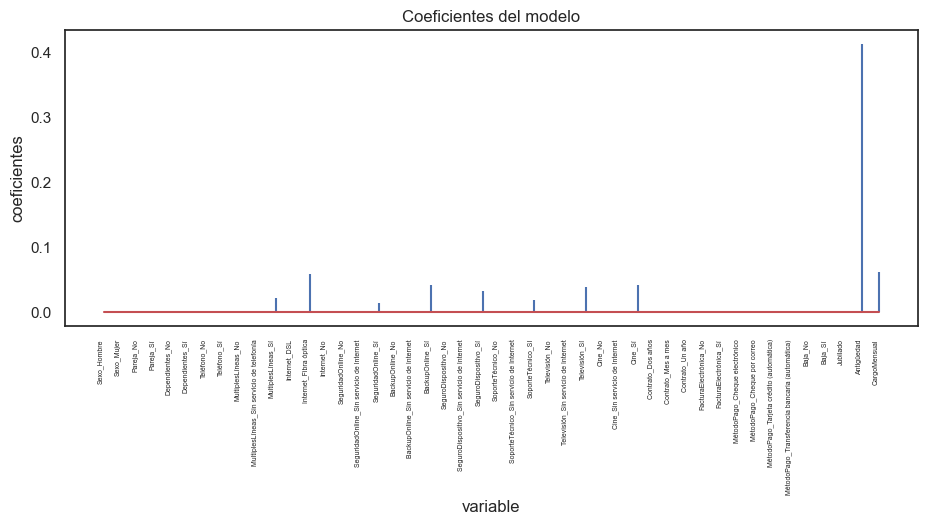

In [42]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [43]:
# Predicciones test
y_test = modelo.predict(X=X_test)
y_test = y_test.flatten()
y_test[:10]

# Error de test del modelo 
rmse_lasso = mean_squared_error(
                y_true  = y_test,
                y_pred  = y_pred,
                squared = False
             )
print("")
print(f"Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred):.4f}")
print(f"Raíz del Error cuadrático medio (MSE): {mean_squared_error(y_test, y_pred,squared=False):.4f}")
print(f"Coeficiente de determinación (R2): {r2_score(y_test, y_pred):.4f}")


Error cuadrático medio (MSE): 0.0031
Raíz del Error cuadrático medio (MSE): 0.0558
Coeficiente de determinación (R2): 0.9223


Hemos conseguido mejorar un poco el MSE, vamos a visualizar para ver este efecto:

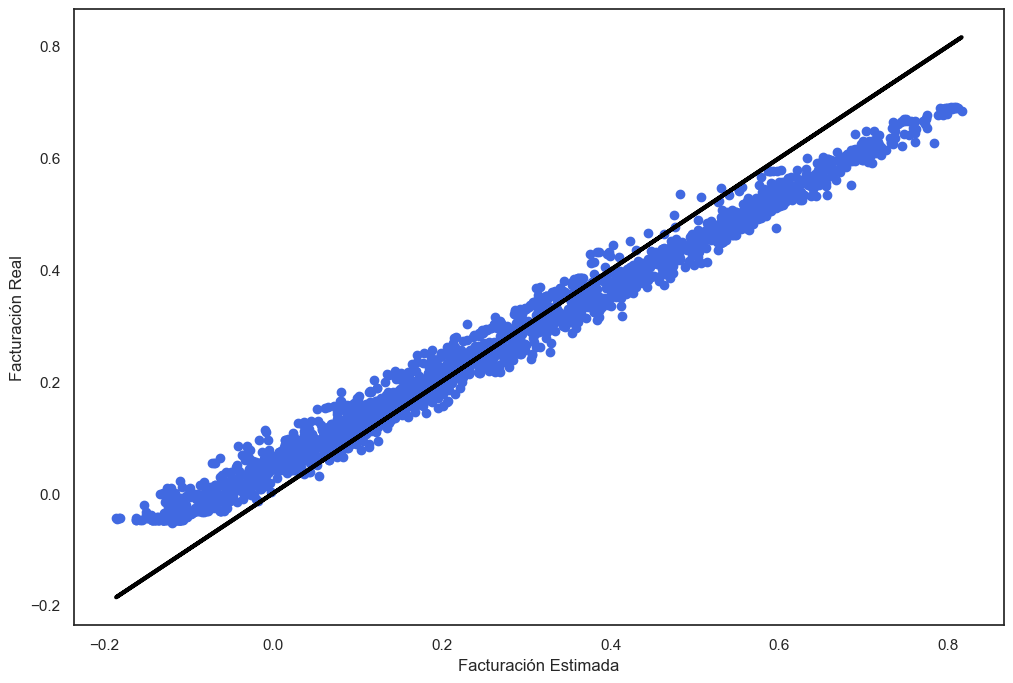

In [44]:

fig, ax = plt.subplots(figsize=(12,8))
plt.scatter(y_pred, y_test,  color='royalblue')
plt.plot(y_pred, y_pred, color='black', linewidth=3)

plt.xlabel('Facturación Estimada')
plt.ylabel('Facturación Real')
plt.show()

Como se puede observar, el efecto de la regularización Lasso, nos ha "concentrado" los puntos, minimizando el MSE.